<a href="https://colab.research.google.com/github/Unoaccaso/ML_final_project/blob/master/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
!rm -rf * # warning
!wget https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1 -O archive.zip
!unzip archive.zip
!7z x beta-beta-decay-identification/data_train.csv.zip -so > data_train.csv
!7z x beta-beta-decay-identification/labels_train.csv.zip -so > labels_train.csv
!rm -rf __MACOSX beta-beta-decay-identification archive.zip

--2020-06-10 18:46:03--  https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip [following]
--2020-06-10 18:46:03--  https://www.dropbox.com/s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc43db618a78b5eba7661b6ce844.dl.dropboxusercontent.com/cd/0/get/A5ZuDG7gZvHXIu0QRaY7GFe1Tm2638D_nX5pD-njeV3gwDzvKzrxsy0-lU4dEqbe2QuIV8NQJqj6FWRqgzlQWXllj020MMyuZQayGhe5f-xfCPDKh_VYfDgQNFS3g6W1QF0/file?dl=1# [following]
--2020-06-10 18:46:03--  https://uc43db618a78b5eba7661b6ce844.dl.dropboxusercontent.com/cd/0/get/A5ZuDG7gZvHXIu0QRaY7GFe1Tm2638D_nX5pD-njeV3gwD

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from time import time

In [0]:
data_train = pd.read_csv('data_train.csv')
labels_train = pd.read_csv('labels_train.csv')

In [0]:
def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    labels = []
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    for i_event in event_ids:
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, bins=(n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        label = labels_train[labels_train["EventID"]==i_event]["Label"].values[0]
        labels.append(label)
    return (np.array(images), np.array(labels))

In [0]:
images, labels = create_images(data_train,
                               n_theta_bins=10, 
                               n_phi_bins=20, 
                               n_time_bins=6)

In [98]:
print(images.shape)
print(labels.shape)

(80000, 10, 20, 6)
(80000,)


# Data manipulation

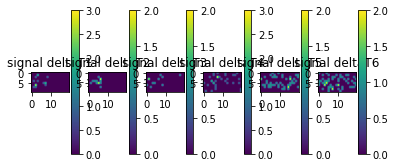

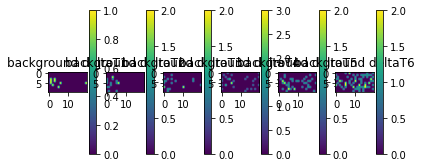

In [143]:
signal = images[labels == 1]
background = images[labels == 0]

sig = np.random.randint(0, signal.shape[0])
back = np.random.randint(0, background.shape[0])

plt.figure()
for i in range(6):
  plt.subplot(1, 6, i+1)
  plot = plt.imshow(signal[sig][:, :, i])
  plt.title(f'signal deltaT{i+1}')
  plt.colorbar(plot)
plt.show()
plt.figure()
for i in range(6):
  plt.subplot(1, 6, i+1)
  plot = plt.imshow(background[back][:, :, i])
  plt.title(f'background deltaT{i+1}')
  plt.colorbar(plot)
plt.show()

# NN training

In [0]:
from sklearn.model_selection import train_test_split
(X_train, X_val, Y_train, Y_val) = train_test_split(images, labels, test_size=0.2)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [102]:
print(X_train.shape)
print(Y_train.shape)

(64000, 10, 20, 6)
(64000,)


In [147]:
IMG_SHAPE = (10, 20, 6)

img_input = keras.Input(shape=IMG_SHAPE, name="D_Image_Input")
x = img_input

# primo blocco Convoluzionale
x = keras.layers.Conv2D(filters=64, kernel_size=3,name='Conv_1', strides=(2, 2))(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = layers.Dropout(0.2, name="DropOut_1")(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(filters=128, kernel_size=2, name='Conv_2', strides=(2, 2))(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = layers.Dropout(0.2, name="DropOut_2")(x)

# terzo blocco Convoluzionale
x = keras.layers.Conv2D(filters=256, kernel_size=2, name='Conv_3', strides=(2, 2))(x)
x = keras.layers.ReLU(name='ReLU_3')(x)
x = layers.Dropout(0.2, name="DropOut_3")(x)

x = keras.layers.Flatten(name='Flatten')(x)

# layer densi
x = keras.layers.Dense(128, name='Dense_1')(x)
x = layers.Dropout(0.2, name="DropOut_4")(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)

outputs = keras.layers.Dense(1, name='Output')(x)

model = keras.Model(inputs=img_input, outputs=outputs, name='predictor')

#printout il summary del modello
model.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D_Image_Input (InputLayer)   [(None, 10, 20, 6)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 4, 9, 64)          3520      
_________________________________________________________________
ReLU_1 (ReLU)                (None, 4, 9, 64)          0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 4, 9, 64)          0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 2, 4, 128)         32896     
_________________________________________________________________
ReLU_2 (ReLU)                (None, 2, 4, 128)         0         
_________________________________________________________________
DropOut_2 (Dropout)          (None, 2, 4, 128)         0 

In [141]:
# learning rate per Adam
LR_ST=1.8e-3

# ottimizzatore
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='cnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [model_checkpoint]    

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(images, labels, validation_split=0.1, batch_size=256, 
          epochs=50, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/100
282/282 [==============================] - 2s 7ms/step - loss: 0.7005 - accuracy: 0.5873 - val_loss: 0.6316 - val_accuracy: 0.6159
Epoch 2/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5947 - accuracy: 0.6887 - val_loss: 0.3137 - val_accuracy: 0.9289
Epoch 3/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5869 - accuracy: 0.6985 - val_loss: 0.6245 - val_accuracy: 0.6456
Epoch 4/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5559 - accuracy: 0.7216 - val_loss: 0.5478 - val_accuracy: 0.7169
Epoch 5/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5902 - accuracy: 0.6911 - val_loss: 1.1059 - val_accuracy: 0.4600
Epoch 6/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5571 - accuracy: 0.7229 - val_loss: 0.2375 - val_accuracy: 1.0000
Epoch 7/100
282/282 [==============================] - 2s 7ms/step - loss: 0.5777 - accuracy: 0.6999 - val_loss: 0.6362 - val_accuracy: 0.7001

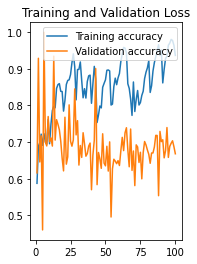


acc:0.50


In [142]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

epochs_range = range(1, len(accuracy) + 1)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.load_weights('cnn_best')
vali_loss, vali_acc = model.evaluate(X_val, Y_val, verbose=0)
print(f'\nacc:{vali_acc:.2f}')